## Differential Photometry

First, we load one of the science frames to highlight the selected stars, the parameter of the sky annulus, the chosen aperture and so on.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from astropy.io import fits
import pickle
import matplotlib.colors as colors

science_list = np.genfromtxt('./group10_WASP-135_20190803/science/science.list', dtype=str)
science_frame_name = './group10_WASP-135_20190803/correct/' + science_list[0][:-5] + '_corr.p'
science_corrected = pickle.load(open(science_frame_name, 'rb'))

The two following functions have been taken from the preivous lectures.

In [71]:
def make_annulus_around_star(x_pos, y_pos, inner_radius, outer_radius, label='', color='y'):
    from matplotlib.patches import Circle

    n, radii = 50, [inner_radius, outer_radius]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=0.75, label=label)


def make_circle_around_star(x_pos, y_pos, radius, thickness=0.5, label='', color='w', alpha=1.):
    from matplotlib.patches import Circle

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=alpha, label=label)


We gather the coordinates for the target and reference stars from the previous lectures:

 - x_target = 228
 - y_target = 33

 - x_reference_01 = 146
 - y_reference_01 = 21

 - x_reference_02 = 194
 - y_reference_02 = 62

 - x_reference_03 = 290
 - y_reference_03 = 93

 - x_reference_04 = 322
 - y_reference_04 = 40

vmin:  1067.9    vmax: 110239.3


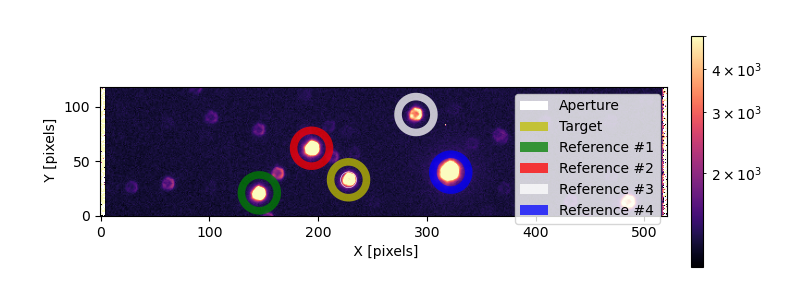

In [72]:
x_target = 228
y_target = 33

x_reference_01 = 146
y_reference_01 = 21

x_reference_02 = 194
y_reference_02 = 62

x_reference_03 = 290
y_reference_03 = 93

x_reference_04 = 322
y_reference_04 = 40

aperture = 7 #6 8
inner_radius = 13
outer_radius = 20

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 5000

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

make_circle_around_star(x_target, y_target, aperture, label='Aperture')

make_annulus_around_star(x_target, y_target, inner_radius, outer_radius, label='Target')
make_annulus_around_star(x_reference_01, y_reference_01, inner_radius, outer_radius, label='Reference #1', color='g')
make_annulus_around_star(x_reference_02, y_reference_02, inner_radius, outer_radius, label='Reference #2', color='r')
make_annulus_around_star(x_reference_03, y_reference_03, inner_radius, outer_radius, label='Reference #3', color='w')
make_annulus_around_star(x_reference_04, y_reference_04, inner_radius, outer_radius, label='Reference #4', color='b')
plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
ax.legend()
plt.show()

### Importing the *AperturePhotometry* class

We now use the **Aperture Photometry** class to perform aperture photometry on the target and reference stars. We select the a maximum of three reference stars so *Reference #4* will not be utilised as it is too bright in fact. In the previous analysis we selected 6 as the ideal aperture, and 13-20 as inner and outer radii.

In [73]:
from aperture_photometry import AperturePhotometry

aperture = 6
inner_radius = 13
outer_radius = 20

target_ap06 = AperturePhotometry()
target_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_target, y_target)

reference01_ap06 = AperturePhotometry()
reference01_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_reference_01, y_reference_01)

reference02_ap06 = AperturePhotometry()
reference02_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_reference_02, y_reference_02)

reference03_ap06 = AperturePhotometry()
reference03_ap06.aperture_photometry(inner_radius, outer_radius, aperture, x_reference_03, y_reference_03)


c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:59: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased /self.median_normalized_flat
c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:59: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased /self.median_normalized_flat
c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:63: RuntimeWarning: divide by zero encountered in divide
  science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2 + (self.median_normalized_flat_error/self.median_normalized_flat)**2)
c:\Users\Lorenzo\Desktop\Università\Magistrale\Astrophysics Laboratory 2\Astrolab2\aperture_photometry.py:63: RuntimeWarning: invalid value encountered in multiply
  science_corrected_error = science_corre

### Tracking weather and instrument conditions during the night

We will now realize a plot with some observables of interest as a function of time:

1. Flux of all stars normalized to the value of the 200th observation (it could be any observation actually) to better compare the flux of stars with different magnitudes.

2. The **AIRMASS** as a function of time.

3. Sky Flux. Higher values may be associated with increasing airmass (light pollution) but also variable weather. Useful if we want to exclude some observations or a reference star if the background has a weird behaviour (due to the presence of a contaminant star near the sky annulus).

4. Variation of the position of the target on the CCD during the night in both directions. You may want to exclude observations affected by sudden jumps.

5. The last panel shows the FWHM of the target, in both directions (NOT IMPLEMENTED IN THE CLASS YET).

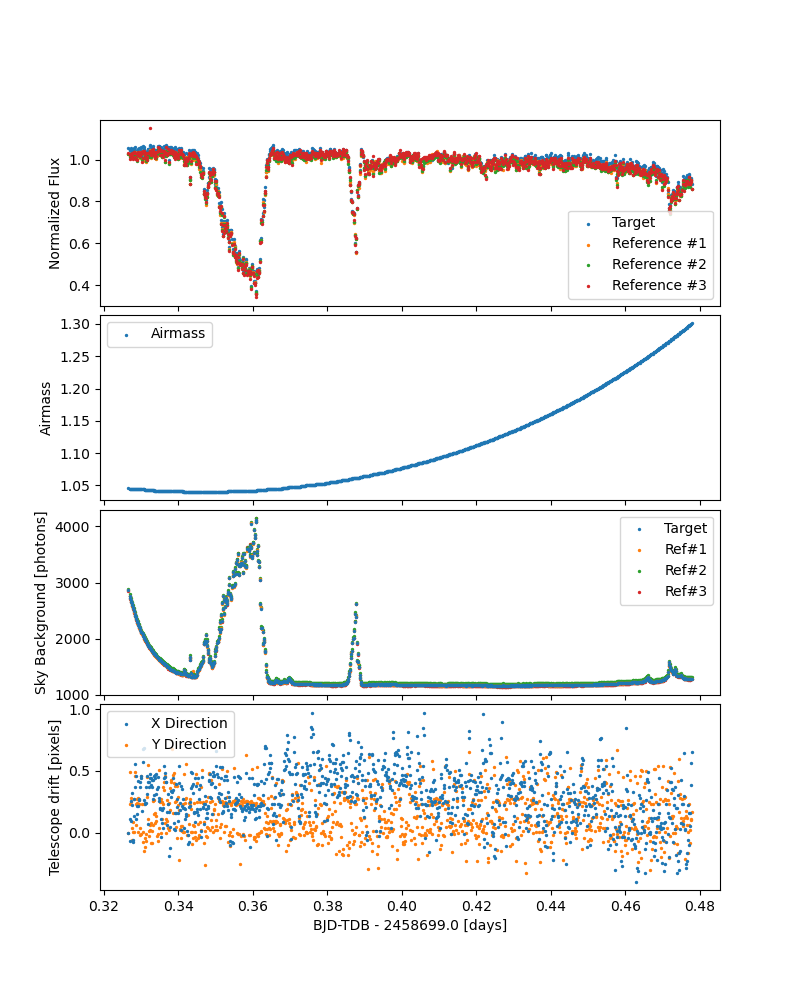

In [79]:

normalization_index = 500 # We divide the flux by the flux of the 200th frame
time_offset = 2458699.0 # This parameter is used only to have values of time close to zero in the plot.

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8,10))
# Reduce vertical space between axes
fig.subplots_adjust(hspace=0.05)

# Normalized Flux Plot
axs[0].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.aperture/target_ap06.aperture[normalization_index], s=2, zorder=3, c='C0', label='Target')
axs[0].scatter(reference01_ap06.bjd_tdb-time_offset, reference01_ap06.aperture/reference01_ap06.aperture[normalization_index], s=2, zorder=3, c='C1', label='Reference #1')
axs[0].scatter(reference02_ap06.bjd_tdb-time_offset, reference02_ap06.aperture/reference02_ap06.aperture[normalization_index], s=2, zorder=3, c='C2', label='Reference #2')
axs[0].scatter(reference03_ap06.bjd_tdb-time_offset, reference03_ap06.aperture/reference03_ap06.aperture[normalization_index], s=2, zorder=3, c='C3', label='Reference #3')
axs[0].set_ylabel('Normalized Flux')


axs[0].legend()

# Airmass Plot
axs[1].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.airmass, s=2, c='C0', label='Airmass')
axs[1].set_ylabel('Airmass')
axs[1].legend()

# Sky Flux Plot
axs[2].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.sky_background, s=2, c='C0', zorder=4, label='Target')
axs[2].scatter(target_ap06.bjd_tdb-time_offset, reference01_ap06.sky_background, s=2, c='C1', zorder=3, label='Ref#1')
axs[2].scatter(target_ap06.bjd_tdb-time_offset, reference02_ap06.sky_background, s=2, c='C2', zorder=2, label='Ref#2')
axs[2].scatter(target_ap06.bjd_tdb-time_offset, reference03_ap06.sky_background, s=2, c='C3', zorder=1, label='Ref#3')

axs[2].set_ylabel('Sky Background [photons]')
axs[2].legend()

# Telescope Drift
axs[3].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.x_position-target_ap06.x_position[0], s=2, c='C0', zorder=2, label='X Direction')
axs[3].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.y_position-target_ap06.y_position[0], s=2, c='C1', zorder=1, label='Y Direction')
axs[3].set_ylabel('Telescope drift [pixels]')
axs[3].legend()
axs[3].set_xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.show()

From these plots it is possible to see that there are some issues with the sky background. It is possible to locate a few peaks probably due to light pollution that have direct consequences on the aperture photometry. We will now examine those frames and see if there is something wrong with them.

C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_6464\1327950594.py:19: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / median_normalized_flat # Correggo per il flat
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_6464\1327950594.py:19: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / median_normalized_flat # Correggo per il flat
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_6464\1327950594.py:22: RuntimeWarning: divide by zero encountered in divide
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_6464\1327950594.py:22: RuntimeWarning: invalid value encountered in multiply
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)


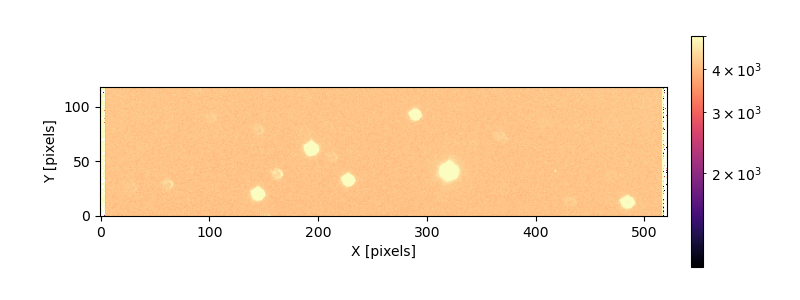

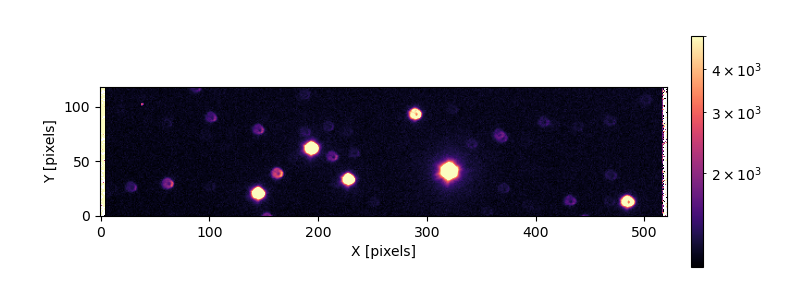

In [75]:
science_list = np.genfromtxt('./group10_WASP-135_20190803/science/science.list', dtype=str)
# Prendiamo i dati salvati
median_bias = pickle.load(open("median_bias.p", "rb"))
median_normalized_flat = pickle.load(open("median_normalized_flat.p", "rb"))
median_normalized_flat_errors = pickle.load(open("median_normalized_flat_errors.p", "rb"))

# Prendiamo i dati rimanenti dai notebook 01 e 02
bias_std = 1.33 # [e] = photoelectrons
readout_noise = 7.10 # [e] = photoelectrons
gain = 1.91 #[e/ADU] from the header file

for i, science_name in enumerate(science_list):
    """Load the science frames, multiply them by the gain, subtract the median_bias,
    divide by the flat. Next we compute the errors."""
    science_fits = fits.open('./group10_WASP-135_20190803/science/' + science_name)
    science_data = science_fits[0].data * gain
    science_fits.close()
    science_debiased = science_data - median_bias # Sottraggo il bias
    science_corrected = science_debiased / median_normalized_flat # Correggo per il flat
    
    science_debiased_errors = np.sqrt(readout_noise**2 + bias_std**2 + science_debiased)
    science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)

    if i==245 or i==550:
        fig, ax = plt.subplots(1, figsize=(8,3))
        im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
        plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)
        plt.xlabel('X [pixels]')
        plt.ylabel('Y [pixels]')
        plt.show()
        

It is possible to observe how the frames corresponding to the peaks in the sky background are characterized by a high background level. This anomaly is probably due to the presence of clouds or atmospheric veils during the observational night. These phenomena reduce the flux received from the star and, at the same time, cause a reflection of artificial light sources from the ground, increasing the value of the sky background.

The initial quadratic decrease, on the other hand, is an expected behavior since the observation began at the beginning of the night, when the sky is still influenced by residual twilight light. This trend is therefore perfectly normal.

Let's plot the sky background error and aperture error to see how to filter those frames.


2458699.323182


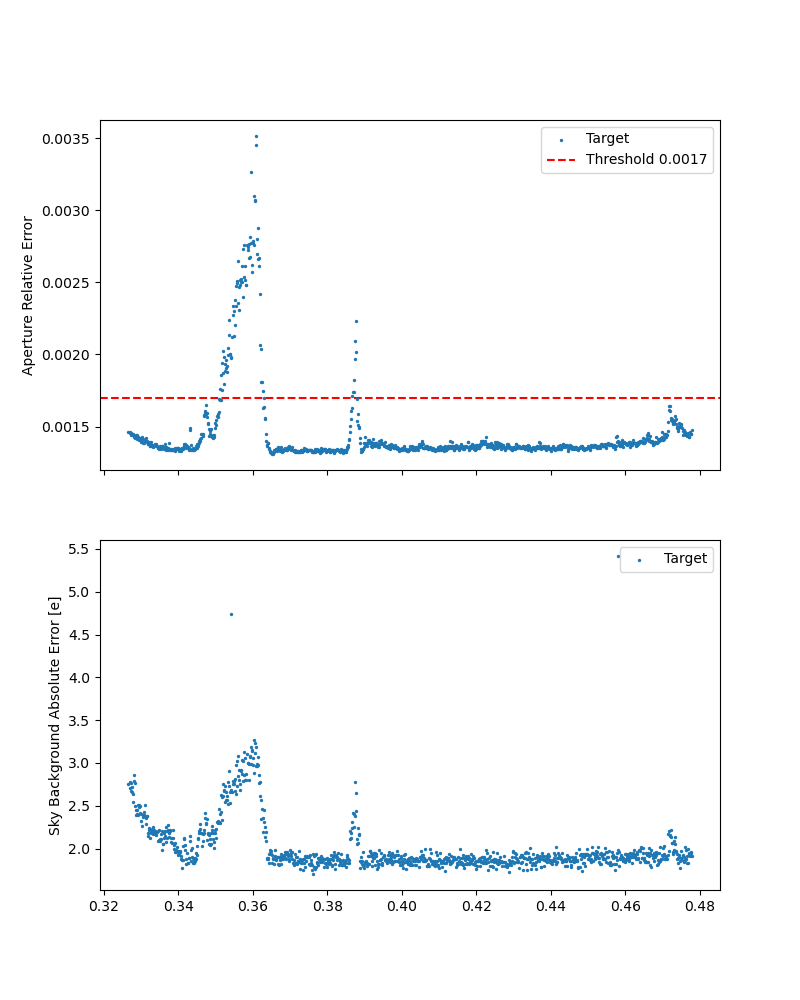

In [76]:
# Verifico che le osservazioni siano iniziate a inizio notte.
print(target_ap06.julian_date[0])
# Corrisponde al 3 agosto 2019 alle 19:45.23 UTC, quindi 20:45.23 locali.

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,10))

# Aperture Relative Error Plot
axs[0].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.aperture_error/target_ap06.aperture, s=2, zorder=3, c='C0', label='Target')
# Linea orizzontale a 0.0017
axs[0].axhline(0.0017, color='r', linestyle='--', label='Threshold 0.0017')
axs[0].set_ylabel('Aperture Relative Error')

axs[0].legend()

# Normalized Flux Plot
axs[1].scatter(target_ap06.bjd_tdb-time_offset, target_ap06.sky_background_error, s=2, zorder=3, c='C0', label='Target')
axs[1].set_ylabel('Sky Background Absolute Error [e]')

axs[1].legend()

We now want to select only the frames which relative error lies below the treshold.

In [77]:
allowed_frame_numbers = []

for i in range(0, len(target_ap06.aperture)):
    relative_error = target_ap06.aperture_error[i]/target_ap06.aperture[i]
    if relative_error <= 0.0017:
        allowed_frame_numbers.append(i)

print(allowed_frame_numbers, len(allowed_frame_numbers))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 178, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,

Now we rewrite the science.list so that it includes only the selected frames, in order to perform aperture photometry.

In [78]:
# Leggi il file e carica tutti i nomi in una lista
with open("./group10_WASP-135_20190803/science/science.list", "r") as f:
    science_list = f.read().splitlines()

# Filtra la lista mantenendo solo gli elementi con indici in allowed_frame_numbers
filtered_science_list = [science_list[i-1] for i in allowed_frame_numbers]  # i-1 perché gli indici in Python partono da 0

# Sovrascrivi il file con la nuova lista filtrata
with open("science.list", "w") as f:
    f.write("\n".join(filtered_science_list) + "\n")
